In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

 50100301922968_1629901911926.pdf
 aadhar-pdf.pdf
'ABSTRACT DIAGRAMMATIC REASONING WITH MULTIPLEX GRAPH NETWORKS.gslides'
 Adv_DL
 analysis.ipynb
 Attendance.gsheet
 Beta-VAE-Tensorflow-2.0-master
 both.png
 cifar-10-batches-py
'Colab Notebooks'
'Copy of E6691.2021Spring.KSRS.sk4824.presentation.gslides'
'Copy of JL_replace_9_to_1_6-JUL-2021.tar.gz'
'Copy of MODL_Presentation.gslides'
 coursework
 Deep-Zork
 disentangled_vae-master
'ELEN6876 Project Proposal-ppt.gslides'
'ELEN E 6889 Seminar.gslides'
 FashionMNIST
 holdout_set.csv
 HW1_210930_205231.pdf
 HW1_210930_205609.pdf
 HW1_210930_205821.pdf
 HW1_210930_234827.pdf
'Hw2 rough_211018_230657 (1).pdf'
'Hw2 rough_211018_231503.pdf'
 hw5_data
 infogan_model
'Information-Maximizing in beta VAE.sk4824.presentationFinal.gslides'
 JW_exp
'Kondamudi_Sairam Satwik_sk4824_MSEE (1).pdf'
'Kondamudi_Sairam Satwik_sk4824_MSEE.pdf'
 LGL
 local_minima_landscape_report.pdf
'Mathematics of deep learning results folder'
'ML-Daniel Hsu.gdoc'
 MNIST
 m

In [ ]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [ ]:
%mkdir 'results_v2'

mkdir: cannot create directory ‘results_v2’: File exists


In [ ]:
%cd 'results_v2'/

/content/drive/MyDrive/results_v2


#METRICS

In [ ]:
import numpy as np
import torch.nn.functional as F
from torch import nn
import torch
from torch.autograd import Variable
import math


class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean') * self.train_size + beta * kl


# def lr_linear(epoch_num, decay_start, total_epochs, start_value):
#     if epoch_num < decay_start:
#         return start_value
#     return start_value*float(total_epochs-epoch_num)/float(total_epochs-decay_start)


def acc(outputs, targets):
    return np.mean(outputs.cpu().numpy().argmax(axis=1) == targets.data.cpu().numpy())


def calculate_kl(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    # kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl


def get_beta(batch_idx, m, beta_type, epoch, num_epochs):
    if type(beta_type) is float:
        return beta_type

    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Soenderby":
        if epoch is None or num_epochs is None:
            raise ValueError('Soenderby method requires both epoch and num_epochs to be passed.')
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = 0
    return beta

#BNN Layers

In [ ]:
class BNNLayer(nn.Module):
    NegHalfLog2PI = -.5 * math.log(2.0 * math.pi)
    softplus = lambda x: math.log(1 + math.exp(x))

    def __init__(self, n_input, n_output, kernel_size, stride=1, padding=0, dilation=1, bias=True, activation = 'relu'):
        # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, priors=None
        
        assert activation in {'relu', 'softmax', 'none'}, 'Activation Type Not Found'

        super(BNNLayer, self).__init__()

        priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        prior_mean, prior_rho = priors['prior_mu'], priors['prior_sigma']
        # Instantiate a large Gaussian block to sample from, much faster than generating random sample every time
        self._gaussian_block = np.random.randn(10000)

        self.n_input = n_input
        self.n_output = n_output
        self.kernel_size = kernel_size #if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.W_mean = nn.Parameter(torch.ones(n_output, n_input, self.kernel_size, device=self.device) * prior_mean)
        self.W_rho = nn.Parameter(torch.ones(n_output, n_input, self.kernel_size, device=self.device) * prior_rho)
        # print(self.W_mean.type(),"+++++++++++++++++++++++++++++++++++++++++")
        # bre

        if self.use_bias:
            self.b_mean = nn.Parameter(torch.ones(n_output, device=self.device) * prior_mean)
            self.b_rho = nn.Parameter(torch.ones(n_output, device=self.device) * prior_rho)
        else:
            self.b_mean = torch.zeros((n_output,), dtype= torch.double).to( self.device)
            self.b_rho = torch.zeros((n_output,), dtype= torch.double).to( self.device)

        self.prior_var = Variable(torch.ones(1, dtype= torch.double, device=self.device) * BNNLayer.softplus(prior_rho) ** 2)
        self.prior_mean = Variable(torch.ones(1, dtype= torch.double, device=self.device) * BNNLayer.softplus(prior_mean) ** 2)

        # Set activation function
        self.act = None
        if activation == 'relu':
            self.act = F.relu
        elif activation == 'softmax':
            self.act = F.softmax

        self._Var = lambda x: Variable(torch.from_numpy(x).type(torch.FloatTensor).to(self.device))

    def forward(self, X, mode='forward'):
        assert mode in {'forward', 'MAP', 'MC'}, 'BNNLayer Mode Not Found'

        # _shape = (X.size()[0], self.n_output)

        # Z: pre-activation. Local reparam. trick is used.

        Z_Mean = F.conv1d(X, self.W_mean, self.b_mean, self.stride, self.padding, self.dilation, self.groups)
        _shape = Z_Mean.size()
        
        # Z_Mean = torch.mm(X, self.W_mean)+ self.b_mean.expand(*_shape)
        # if self.use_bias:
        #  Z_Mean = Z_Mean + 

        if mode == 'MAP': return self.act(Z_Mean) if self.act is not None else Z_Mean

        x_std = torch.pow(X, 2)
        weight_std = torch.pow(F.softplus(self.W_rho), 2)
        b_std = torch.pow(F.softplus(self.b_rho), 2)

        Z_Std = torch.sqrt(F.conv1d(x_std, weight_std, b_std, self.stride, self.padding, self.dilation, self.groups))

        # Z_Std = torch.sqrt(
        #     torch.mm(torch.pow(X, 2),
        #              torch.pow(F.softplus(self.W_rho), 2)) +
        #     torch.pow(F.softplus(self.b_rho.expand(*_shape)), 2)
        # )

        Z_noise = self._random(_shape)
        Z = Z_Mean + Z_Std * Z_noise

        if mode == 'MC': return self.act(Z) if self.act is not None else Z

        # Stddev for the prior
        # Prior_Z_Std = torch.sqrt(
        #     torch.mm(torch.pow(X, 2),
        #              self.prior_var.expand(self.n_input, self.n_output)) +
        #     self.prior_var.expand(*_shape)
        # ).detach()
        #self.prior_var.expand(self.n_input, self.n_output, self.kernel_size)
        prior_w = self.prior_var.expand(self.n_output, self.n_input, self.kernel_size)
        prior_b = self.prior_var.expand(self.n_output)#.view(1,-1,1)
        Prior_Z_Std = torch.sqrt(F.conv1d(x_std, prior_w, prior_b, self.stride, self.padding, self.dilation, self.groups)).detach()

        out = self.act(Z) if self.act is not None else Z

        # return out, 0
        # KL[posterior(w|D)||prior(w)]
        layer_KL = self.sample_KL(Z,
                                  Z_Mean, Z_Std,
                                  Z_Mean.detach(), Prior_Z_Std)

        
        return out, layer_KL

    def _random(self, shape):
        Z_noise = np.random.choice(self._gaussian_block, size=shape[0] * shape[1]*shape[2])
        Z_noise = np.expand_dims(Z_noise, axis=1).reshape(*shape)
        return self._Var(Z_noise)

    @staticmethod
    def log_gaussian(x, mean, std):
        return BNNLayer.NegHalfLog2PI - torch.log(std) - .5 * torch.pow(x - mean, 2) / torch.pow(std, 2)

    @staticmethod
    def sample_KL(x, mean1, std1, mean2, std2):
        log_prob1 = BNNLayer.log_gaussian(x, mean1, std1)
        log_prob2 = BNNLayer.log_gaussian(x, mean2, std2)
        return (log_prob1 - log_prob2).sum()

In [ ]:
from torch import nn
import sys
sys.path.append("..")

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
# from metrics import calculate_kl as KL_DIV
KL_DIV = calculate_kl


class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()

        return x, kl


class FlattenLayer(ModuleWrapper):

    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)

class BBBConv1d(ModuleWrapper):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None):

        super(BBBConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size #if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_channels, in_channels, self.kernel_size), device=self.device))
        self.W_rho = Parameter(torch.empty((out_channels, in_channels, self.kernel_size), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            # print(self.W_mu,"+++++++++++++++++++")
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
        else:
            # print(self.W_mu,"-----------------------")
            weight = self.W_mu
            bias = self.bias_mu if self.use_bias else None

        return F.conv1d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)

    def kl_loss(self, size):
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl/size

#LISTA

In [ ]:
"""
@author: yinchuan li
@version: 2020.03.12
Change to complex-valued network
Off-grid LISTA net - Only the training data changed to off-grid data
Learning W1 and W2
A CNN is added: x = f(W1,W2,x) + CNN(x)
"""
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
import os
import time
# from BNN_layers import BBBConv1d


def soft_comp(x, threshold):
    mask1 = x > threshold
    mask2 = x < -threshold
    out = torch.zeros_like(x)
    out += mask1.float() * -threshold + mask1.float() * x
    out += mask2.float() * threshold + mask2.float() * x
    return out


class LISTA(nn.Module):
    def __init__(self, _w1_, _w2_, C, stage, alpha, thr, useGPU, size):
        super(LISTA, self).__init__()
        self.alpha = alpha
        self.stage = stage
        self._flat_weights_names = []
        self._all_weights = []
        self.n = _w2_.shape[0]
        self.size = size

        if (useGPU):
            self.C_real = (nn.Parameter(torch.from_numpy(C.real))).cuda()
            self.C_imag = (nn.Parameter(torch.from_numpy(C.imag))).cuda()
        else:
            self.C_real = nn.Parameter(torch.from_numpy(C.real))
            self.C_imag = nn.Parameter(torch.from_numpy(C.imag))

        for layer in range(stage):

            conv1d_1 = BNNLayer(1,2,4,padding=1, bias=False)#BBBConv1d(1,2,4,padding=1, bias=False)#nn.Conv1d(1, 2, 4, padding=1)   #
            # # 加上一层relu
            conv1d_2 = BNNLayer(2,1,2,padding=1, bias=False) #BBBConv1d(2,1,2,padding=1, bias=False)#nn.Conv1d(2, 1, 2, padding=1)   # output channel is one

            conv1d_3 = BNNLayer(1,2,4,padding=1, bias=False) #BBBConv1d(1,2,4,padding=1, bias=False)#nn.Conv1d(1, 2, 4, padding=1)

            conv1d_4 = BNNLayer(2,1,2,padding=1, bias=False) #BBBConv1d(2,1,2,padding=1, bias=False)#nn.Conv1d(2, 1, 2, padding=1)

            conv1d_1 = conv1d_1.double()
            conv1d_2 = conv1d_2.double()

            conv1d_3 = conv1d_3.double()
            conv1d_4 = conv1d_4.double()

            w_real = nn.Parameter(torch.from_numpy(_w2_.real))
            w_imag = nn.Parameter(torch.from_numpy(_w2_.imag))
            b_real = nn.Parameter(torch.from_numpy(_w1_.real))
            b_imag = nn.Parameter(torch.from_numpy(_w1_.imag))

            th = nn.Parameter(torch.tensor(thr))

            if (useGPU):
                conv1d_1 = conv1d_1.cuda()
                conv1d_2 = conv1d_2.cuda()
                conv1d_3 = conv1d_3.cuda()
                conv1d_4 = conv1d_4.cuda()
                w_real = w_real.cuda()
                w_imag = w_imag.cuda()
                b_real = b_real.cuda()
                b_imag = b_imag.cuda()
                th = th.cuda()

            layer_params = (w_real, w_imag, b_real, b_imag, th, conv1d_1, conv1d_2, conv1d_3, conv1d_4)
            suffix = ''
            param_names = ['weights_real_{}{}', 'weights_imag_{}{}',
                           'bias_real_{}{}', 'bias_imag_{}{}', 'threshold{}{}', 'conv1d_1_{}{}', 'conv1d_2_{}{}', 'conv1d_3_{}{}', 'conv1d_4_{}{}']
            param_names = [x.format(layer, suffix) for x in param_names]
            for name, param in zip(param_names, layer_params):
                setattr(self, name, param)
            self._flat_weights_names.extend(param_names)
            self._all_weights.append(param_names)


    def forward(self, y_real, y_imag, mode = 'MC'):
        self.bs = y_real.shape[-1]
        '''
                # param_names = ['weights_real_{}{}', 'weights_imag_{}{}',
                #                'bias_real_{}{}', 'bias_imag_{}{}', 'threshold{}{}']
                # w2_real, w2_imag, w1_real, w1_imag, threshold
        '''

        x_real = torch.zeros([self.n, self.bs],dtype=torch.float64)
        x_imag = torch.zeros([self.n, self.bs],dtype=torch.float64)

        if (y_real.is_cuda):
            x_real = x_real.cuda()
            x_imag = x_imag.cuda()

        # from the first layer to the last layer, where in the first layer x=0
        kl_loss = 0
        for layer in range(self.stage):
            param_names = self._all_weights[layer][:]

            z_org_real = getattr(self, param_names[0]).mm(x_real) - \
                         getattr(self, param_names[1]).mm(x_imag) + \
                         getattr(self, param_names[2]).mm(y_real) - \
                         getattr(self, param_names[3]).mm(y_imag)

            z_org_imag = getattr(self, param_names[0]).mm(x_imag) + \
                         getattr(self, param_names[1]).mm(x_real) + \
                         getattr(self, param_names[2]).mm(y_imag) + \
                         getattr(self, param_names[3]).mm(y_real)

            conv1d_1 = getattr(self, param_names[5])
            conv1d_2 = getattr(self, param_names[6])

            
            conv1d_3 = getattr(self, param_names[7])
            conv1d_4 = getattr(self, param_names[8])

            # x_cnn_real = (conv1d_1(x_real.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
            # x_cnn_imag = (conv1d_1(x_imag.T.view(self.bs, 1, self.n))).view(self.bs, self.n).T
            if mode == 'forward':
              x_cnn_real, real_kl_loss1 = conv1d_1(x_real.T.view(self.bs, 1, self.n), mode = mode)
              x_cnn_real, real_kl_loss2 = conv1d_2(x_cnn_real, mode=mode)
              x_cnn_real = x_cnn_real.view(self.bs, self.n).T
              x_cnn_imag, imag_kl_loss1 = conv1d_3(x_imag.T.view(self.bs, 1, self.n), mode = mode)
              x_cnn_imag, imag_kl_loss2 = conv1d_4(x_cnn_imag, mode=mode)
              x_cnn_imag = x_cnn_imag.view(self.bs, self.n).T
              kl_loss+=real_kl_loss1+real_kl_loss2+imag_kl_loss1+imag_kl_loss2
            else:
              x_cnn_real = (conv1d_2(conv1d_1(x_real.T.view(self.bs, 1, self.n), mode=mode),mode=mode)).view(self.bs, self.n).T
              x_cnn_imag = (conv1d_4(conv1d_3(x_imag.T.view(self.bs, 1, self.n),mode=mode), mode=mode)).view(self.bs, self.n).T
            
            # kl_loss+= conv1d_1.kl_loss(self.size)+conv1d_2.kl_loss(self.size)+conv1d_3.kl_loss(self.size)+conv1d_4.kl_loss(self.size)

            x_real = soft_comp(z_org_real, getattr(self, param_names[4])) + x_cnn_real
            x_imag = soft_comp(z_org_imag, getattr(self, param_names[4])) + x_cnn_imag

        Cx_real = self.C_real.mm(x_real) - self.C_imag.mm(x_imag)
        Cx_imag = self.C_imag.mm(x_real) + self.C_real.mm(x_imag)
        return Cx_real, Cx_imag, x_real, x_imag, 0 # kl_loss


def my_loss_y(A_real, A_imag, x_real, x_imag, y_real, y_imag):
    criterion1 = nn.MSELoss()
    # criterion2 = L1Loss_comp
    y_h_real = torch.mm(A_real, x_real) - torch.mm(A_imag, x_imag)
    y_h_imag = torch.mm(A_imag, x_real) + torch.mm(A_real, x_imag)
    # compute the losss
    loss1 = criterion1(y_h_real, y_real) + criterion1(y_h_imag, y_imag)
    # loss2 = 0.1 * _lambda * criterion2(y_h_real, y_h_imag, y_real, y_imag)
    return loss1


def my_loss_nmse(x_real, x_imag, x_gt_real, x_gt_imag):
    x_real[x_real < 1e-8] = 2e-8
    x_imag[x_real < 1e-8] = 2e-8
    x_gt_real[x_gt_real < 1e-8] = 1e-8
    x_gt_imag[x_gt_imag < 1e-8] = 1e-8
    x_nmse = 0
    for i in range(x_real.shape[1]):
        x_gt_norm = torch.sum(x_gt_real[:, i] ** 2 + x_gt_imag[:, i] ** 2)
        sub_norm = torch.sum((x_real[:, i] - x_gt_real[:, i]) ** 2 + (x_imag[:, i] - x_gt_imag[:, i]) ** 2)
        x_nmse += sub_norm / x_gt_norm
    return x_nmse / x_real.shape[1]


def my_loss_x(x_real, x_imag, x_gt_real, x_gt_imag):
    criterion1 = nn.MSELoss()
    plot_flag = 0

    # compute the losss
    loss1 = (criterion1(x_real, x_gt_real)  # *(x_gt_real.shape[0]*x_gt_real.shape[1])/ non_zero_real
             + criterion1(x_imag, x_gt_imag))  # *(x_gt_imag.shape[0]*x_gt_imag.shape[1])/ non_zero_imag


    if plot_flag:
        xi = x_imag.detach().numpy()[:, 0]
        xr = x_real.detach().numpy()[:, 0]
        xi_gt = x_gt_imag.detach().numpy()[:, 0]
        xr_gt = x_gt_real.detach().numpy()[:, 0]
        plt.figure()
        plt.subplot(311)
        plt.stem(range(xi.shape[0]), xi, use_line_collection=True, markerfmt='D', label='LISTA')
        plt.stem(range(xi_gt.shape[0]), xi_gt, use_line_collection=True, markerfmt='o', label='Ground_truth')
        plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Real Part")

        plt.subplot(312)
        plt.stem(range(xr.shape[0]), xr, markerfmt='D', label='LISTA')
        plt.stem(range(xr_gt.shape[0]), xr_gt, use_line_collection=True, markerfmt='o', label='Ground_truth')
        plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Imag Part")

        plt.subplot(313)
        plt.stem(range(xi.shape[0]), np.sqrt(xi ** 2 + xr ** 2), use_line_collection=True, markerfmt='D', label='LISTA')
        plt.stem(range(xi_gt.shape[0]), np.sqrt(xi_gt ** 2 + xr_gt ** 2), use_line_collection=True, markerfmt='o',
                 label='Ground_truth')
        plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
        plt.title("LISTA-Net Imag Part")
        plt.show()

    return loss1


def L1Loss_comp(input_real, input_imag, target_real, target_imag):
    return torch.mean(torch.sqrt((input_real - target_real) ** 2 + (input_imag - target_imag) ** 2))



def now_to_date(format_string="%Y-%m-%d-%H-%M-%S"):
    time_stamp = int(time.time())
    time_array = time.localtime(time_stamp)
    str_date = time.strftime(format_string, time_array)
    return str_date


def save_my_data(y_train, x_train, y_valid, x_valid, path_data='data/LISTA_Train_Valid_Data/'):
    print('===> Saving data...')
    str_date = now_to_date()
    data = {
        'train_data': y_train,
        'train_label': x_train,
        'valid_data': y_valid,
        'valid_label': x_valid}
    if not os.path.isdir(path_data):
        os.makedirs(path_data)
    torch.save(data, path_data + 'data-' + str_date + '.pt')
    print('===> Saving data finished...')


def save_my_model(net, optimizer, epochs, loss_list, loss_val_list, learning_rate, stage,
                  path_checkpoint='model/LISTA-Update-Weights/checkpoint/'):
    print('===> Saving models...')
    str_date = now_to_date()
    state = {
        'epoch': epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_list,
        'loss_val': loss_val_list,
        'learning_rate': learning_rate,
        'stage': stage
    }
    # path_checkpoint = 'model/LISTA-Updata-Weights/checkpoint/'
    if not os.path.isdir(path_checkpoint):
        os.makedirs(path_checkpoint)
    torch.save(state, path_checkpoint + 'LISTA_net-' + str_date + '.pt')
    print('===> Saving model finished...')


def loss_graph_plotter(train_loss_list, val_loss_list):
    plt.figure()
    x_axis = list(range(len(train_loss_list)))
    plt.plot(x_axis, train_loss_list, color='blue', label='train_loss')
    plt.plot(x_axis, val_loss_list, color='red', label='validation_loss')
    plt.title('loss curve')
    plt.legend()
    plt.show()
    plt.savefig('loss_curve_bbb_v2.jpg')




def my_lista(A, C, Phi, y_train, x_train, y_valid, x_valid, _lambda, alpha, bs, epochs,stage, learning_rate):
    useGPU = 1
    nt = y_train.shape[-1]
    nv = y_valid.shape[-1]
    M = y_train.shape[0]/bs

    # batch_size = y_train.shape[-1]

    _w2_ = (np.eye(A.shape[-1]) - (1 / alpha) * np.matmul(A.conj().T, A))  # note that here is the conjugate transpose
    _w1_ = ((1 / alpha) * A.conj().T)
    # map
    # convert the data into tensors
    C_real = torch.from_numpy(C.real)
    C_imag = torch.from_numpy(C.imag)
    y_real = torch.from_numpy(y_train.real)
    y_imag = torch.from_numpy(y_train.imag)
    y_gt_real = torch.from_numpy(x_train.real)
    y_gt_imag = torch.from_numpy(x_train.imag)
    yt_real = torch.from_numpy(y_valid.real)
    yt_imag = torch.from_numpy(y_valid.imag)
    yt_gt_real = torch.from_numpy(x_valid.real)
    yt_gt_imag = torch.from_numpy(x_valid.imag)

    if (useGPU):
        y_real = y_real.cuda()
        y_imag = y_imag.cuda()
        y_gt_real = y_gt_real.cuda()
        y_gt_imag = y_gt_imag.cuda()
        yt_real = yt_real.cuda()
        yt_imag = yt_imag.cuda()
        yt_gt_real = yt_gt_real.cuda()
        yt_gt_imag = yt_gt_imag.cuda()

    # list of losses at every epoch
    loss_list = []
    loss_val_list = []
    # ------- Training phase --------------
    # number of layers:
    # stage = 10
    net = LISTA(_w1_, _w2_, C, stage, alpha=alpha, thr=_lambda / alpha, useGPU=useGPU, size= M)

    # learning_rate = 0.01
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    print(len(list(net.parameters())),"************************************")
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # momentum=0.9
    # optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, momentum=0.9) # momentum=0.9
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) #

    for epoch in range(epochs):

        # if epoch < 100:
        #     learning_rate = 1e-3
        # elif epoch < 200:
        #     learning_rate = 1e-4
        # else:
        #     learning_rate = 1e-6

        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # momentum=0.9
        train_loss_calc_list = []

        for i in range((nt - 1) // bs + 1):
            # get the outputs
            start_i = i * bs
            end_i = start_i + bs
            ye_real, ye_imag, x_real, x_imag, kl_loss = net(y_real[:, start_i:end_i], y_imag[:, start_i:end_i], mode='forward')
            if(useGPU):
                ye_real = ye_real.cuda()
                ye_imag = ye_imag.cuda()
                x_real = x_real.cuda()
                x_imag = x_imag.cuda()
            optimizer.zero_grad()
            loss = my_loss_x(ye_real, ye_imag, y_gt_real[:, start_i:end_i], y_gt_imag[:, start_i:end_i]) + kl_loss
            loss.backward()
            optimizer.step()
            if i % 200 == 0:
                print('Epoch: %d mini-batch: %d  train-loss: %.5f ' % (epoch, i + 1, loss.detach().data))
            train_loss_calc_list.append(loss.detach().data)
            # [x.item() for x in val_loss_calc_list]
        avg_train_loss = np.mean([x.item() for x in train_loss_calc_list])
        print('Epoch: %d average train-loss: %.5f ' % (epoch, avg_train_loss))
        loss_list.append(avg_train_loss)
        val_loss_calc_list = []
        with torch.no_grad():
            for i in range((nv - 1) // (2 * bs) + 1):
                start_i = i * (2 * bs)
                end_i = start_i + (2 * bs)
                y_pred_real, y_pred_imag, x_pred_real, x_pred_imag, _kl = net(yt_real[:, start_i:end_i], yt_imag[:, start_i:end_i], mode='MAP')

                loss_val = my_loss_x(y_pred_real, y_pred_imag,
                                        yt_gt_real[:, start_i:end_i], yt_gt_imag[:, start_i:end_i]) +_kl
                # if i % 10 == 0:
                #     print('Epoch: %d mini-batch: %d  valid-loss %.2f'%(epoch, i, loss_val.detach().data))
                val_loss_calc_list.append(loss_val.detach().data)

            # print('Epoch: %d  mean-valid-loss %.5f' % (epoch, np.mean(print_valid_loss)))
            avg_loss_for_epoch = np.mean([x.item() for x in val_loss_calc_list])
            print('Epoch: %d  mean-valid-loss %.5f' % (epoch, avg_loss_for_epoch))
            loss_val_list.append(val_loss_calc_list)


    loss_graph_plotter(loss_list, loss_val_list)
    save_my_model(net, optimizer, epochs, loss_list, loss_val_list, learning_rate, stage,
                  path_checkpoint='model/LISTA-Update-Weights/checkpoint/')
    # save_my_data(y_train, x_train, y_valid, x_valid, path_data='data/LISTA_Train_Valid_Data/')

    real_pred, imag_pred = [], []
    with torch.no_grad():
        for i in range((nv - 1) // (2 * bs) + 1):
            start_i = i * (2 * bs)
            end_i = start_i + (2 * bs)
            real, imag, _, _, _ = net.forward(yt_real[:, start_i:end_i], yt_imag[:, start_i:end_i], mode='MAP')
            real_pred.append(real)
            imag_pred.append(imag)
    real_pred = torch.cat(real_pred, dim=1)
    imag_pred = torch.cat(imag_pred, dim=1)
    print(my_loss_nmse(real_pred, imag_pred, yt_gt_real, yt_gt_imag),"++++++++++++++++++++++++++++++++")

    if (useGPU):
        y_pred_real = y_pred_real.cpu()
        y_pred_imag = y_pred_imag.cpu()
        x_pred_real = x_pred_real.cpu()
        x_pred_imag = x_pred_imag.cpu()

    return y_pred_real.numpy(), y_pred_imag.numpy(), x_pred_real.numpy(), x_pred_imag.numpy(), loss_list




#MAIN_E_BBB

48 ************************************
Epoch: 0 mini-batch: 1  train-loss: 2410.60483 
Epoch: 0 mini-batch: 201  train-loss: 273.68309 
Epoch: 0 average train-loss: 609.30860 
Epoch: 0  mean-valid-loss 1.51180
Epoch: 1 mini-batch: 1  train-loss: 213.46173 
Epoch: 1 mini-batch: 201  train-loss: 129.31142 
Epoch: 1 average train-loss: 156.59257 
Epoch: 1  mean-valid-loss 1.51180
Epoch: 2 mini-batch: 1  train-loss: 112.13482 
Epoch: 2 mini-batch: 201  train-loss: 82.99220 
Epoch: 2 average train-loss: 95.46922 
Epoch: 2  mean-valid-loss 1.51180
Epoch: 3 mini-batch: 1  train-loss: 81.15135 
Epoch: 3 mini-batch: 201  train-loss: 65.30690 
Epoch: 3 average train-loss: 70.25167 
Epoch: 3  mean-valid-loss 1.51180
Epoch: 4 mini-batch: 1  train-loss: 60.08023 
Epoch: 4 mini-batch: 201  train-loss: 54.07930 
Epoch: 4 average train-loss: 56.38630 
Epoch: 4  mean-valid-loss 1.51180
Epoch: 5 mini-batch: 1  train-loss: 51.53224 
Epoch: 5 mini-batch: 201  train-loss: 44.05614 
Epoch: 5 average train-

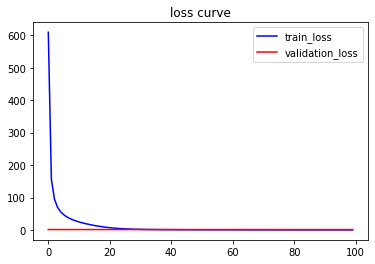

===> Saving models...
===> Saving model finished...
tensor(0.6135, device='cuda:0', dtype=torch.float64) ++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

<Figure size 432x288 with 0 Axes>

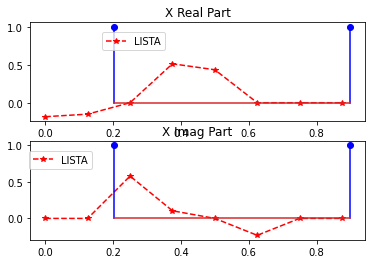

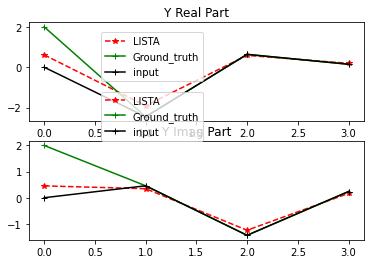

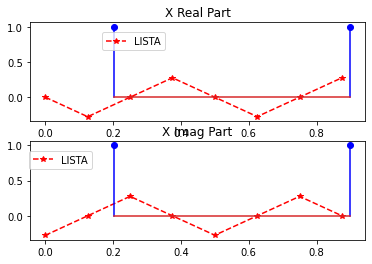

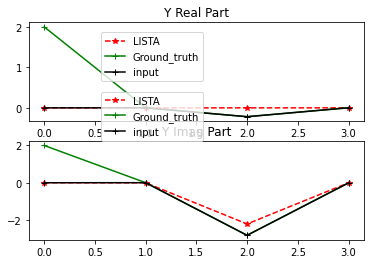

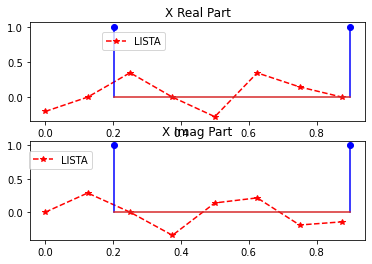

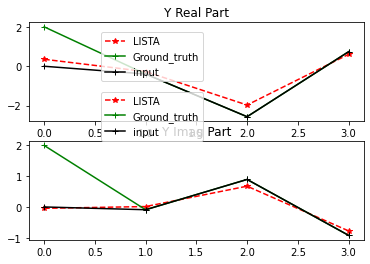

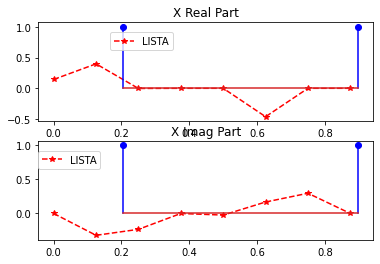

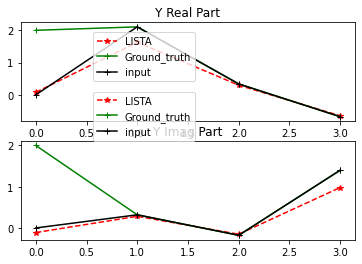

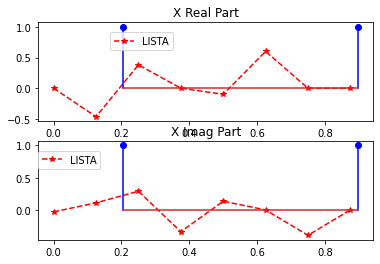

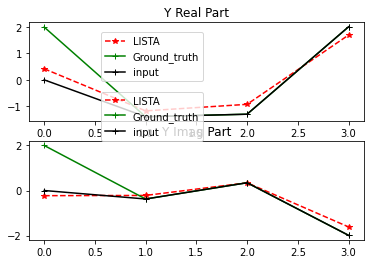

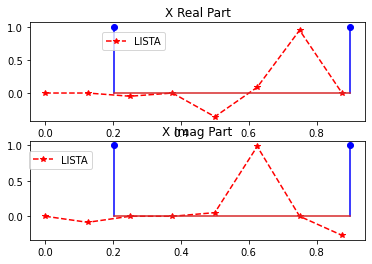

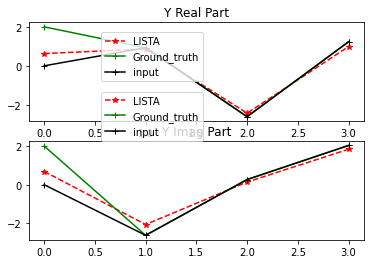

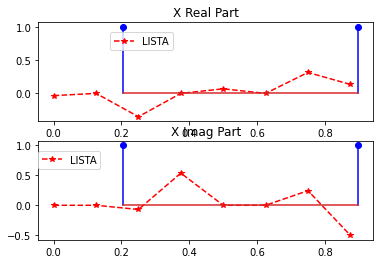

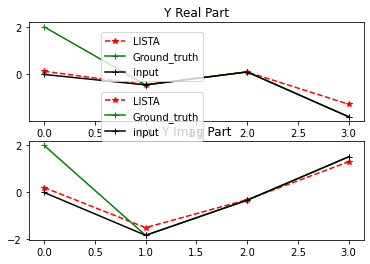

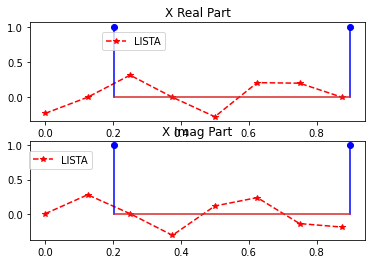

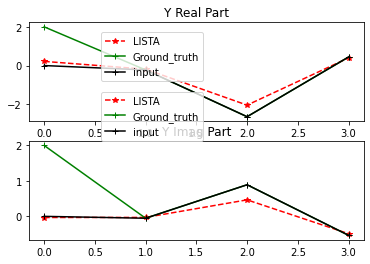

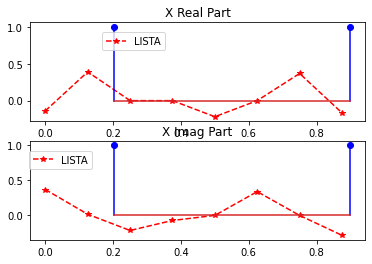

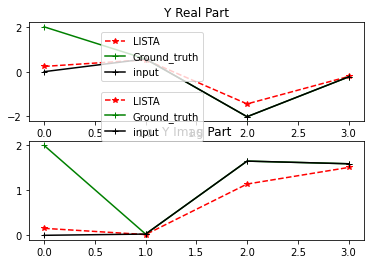

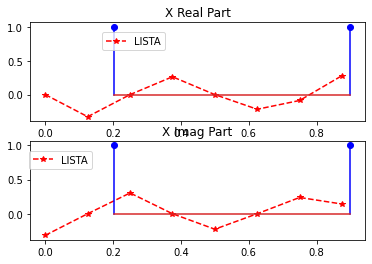

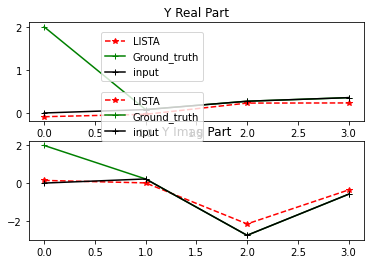

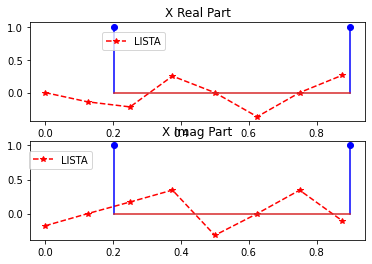

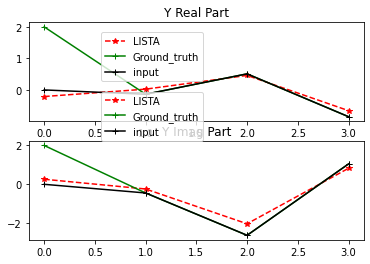

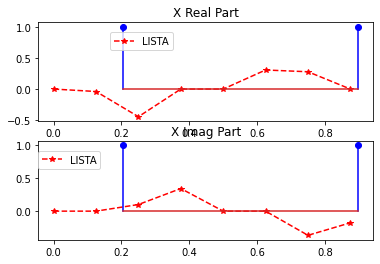

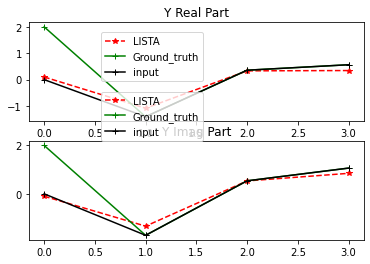

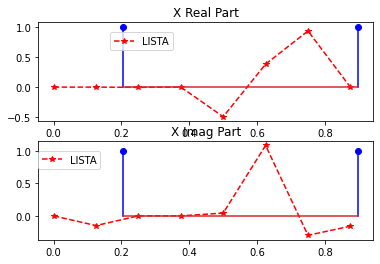

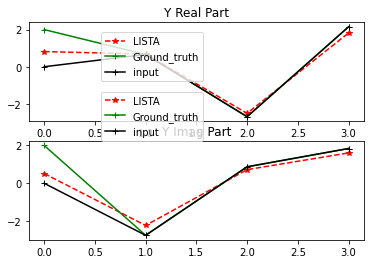

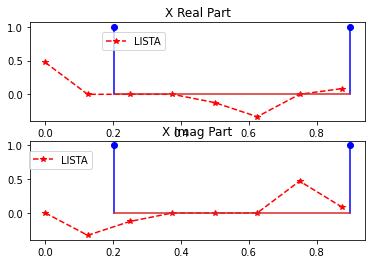

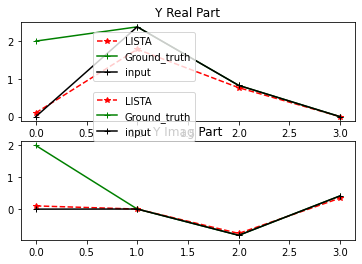

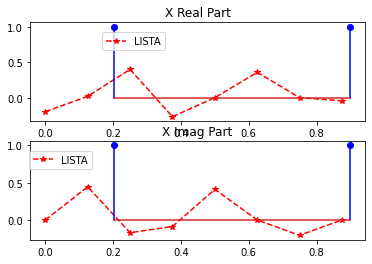

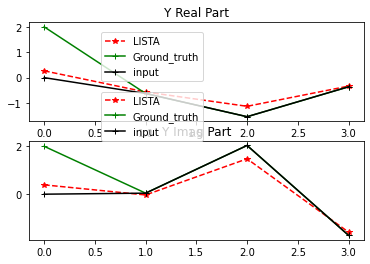

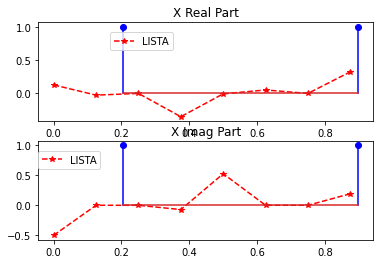

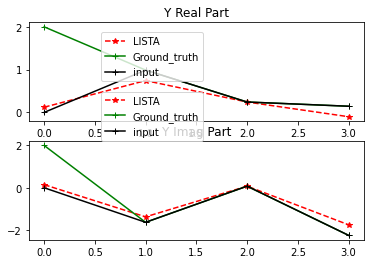

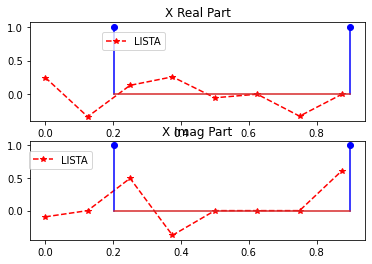

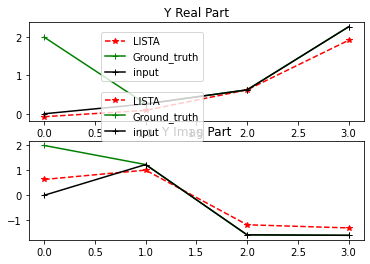

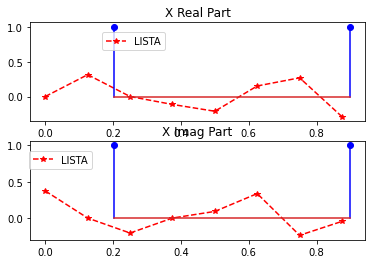

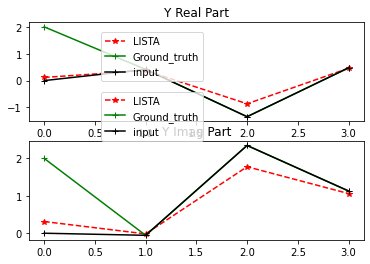

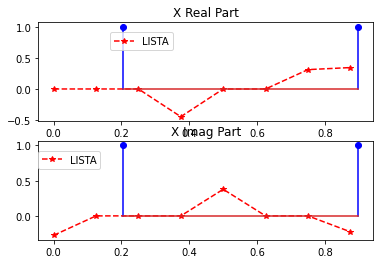

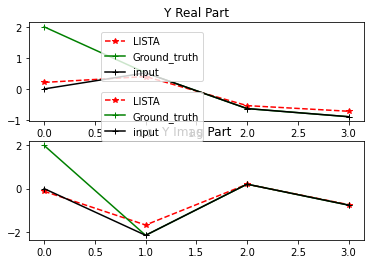

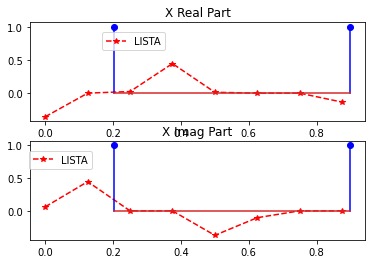

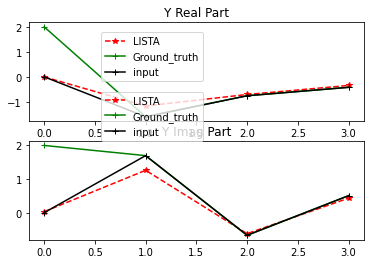

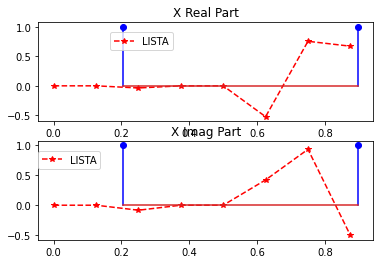

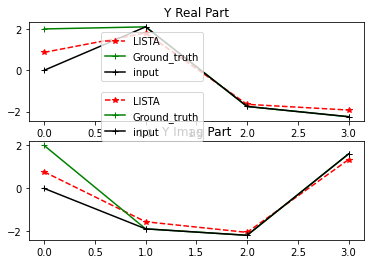

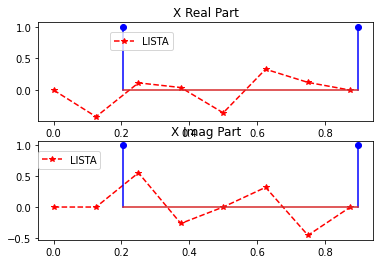

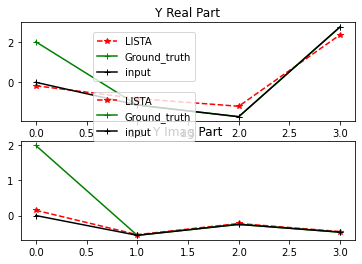

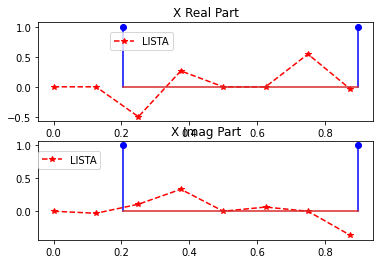

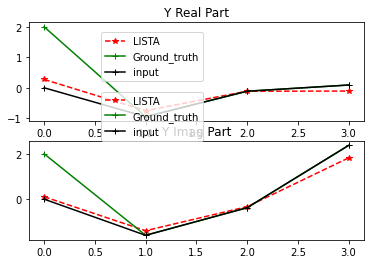

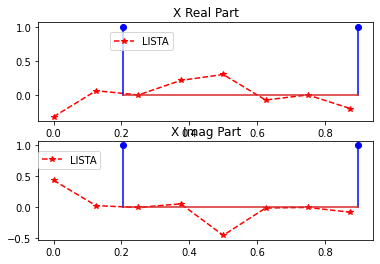

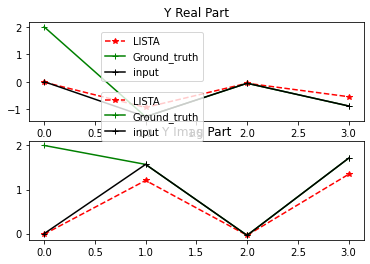

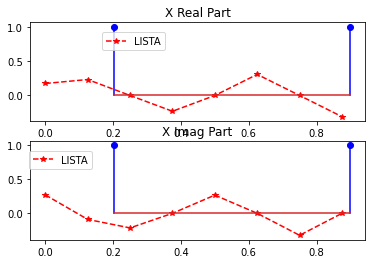

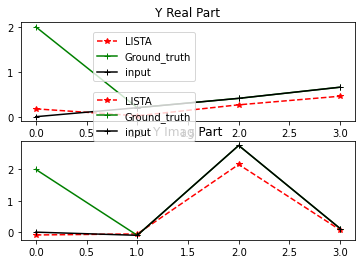

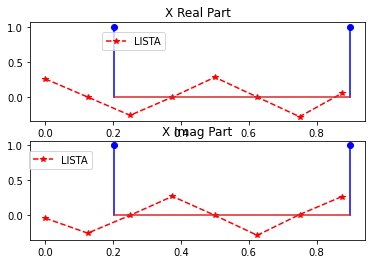

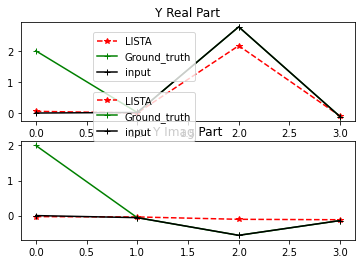

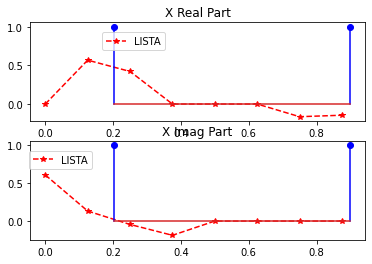

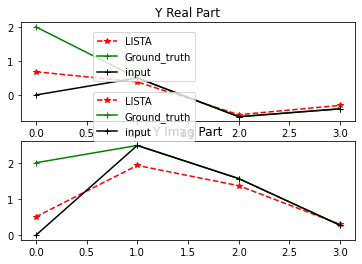

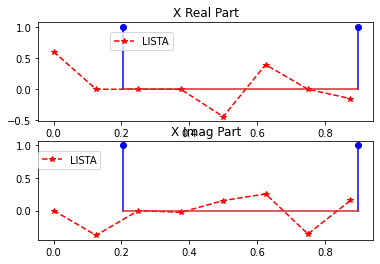

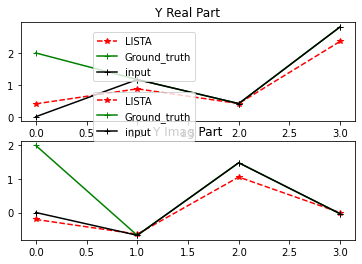

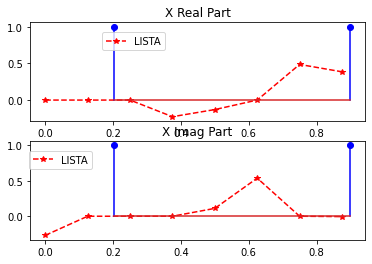

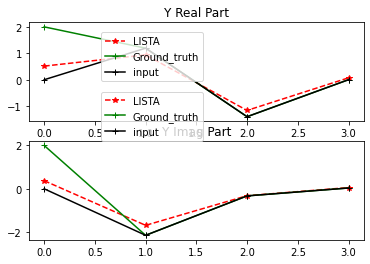

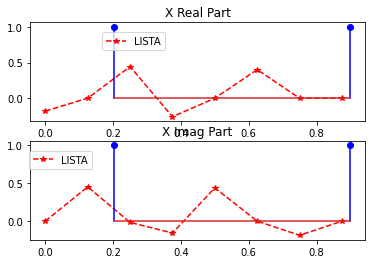

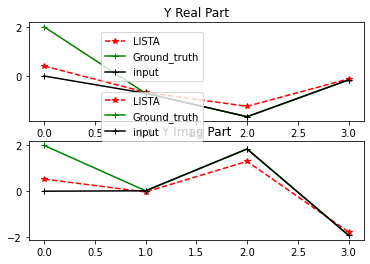

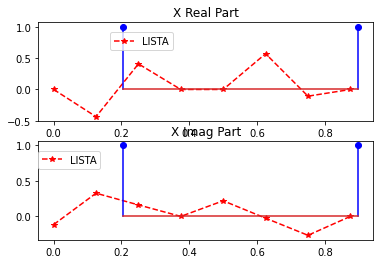

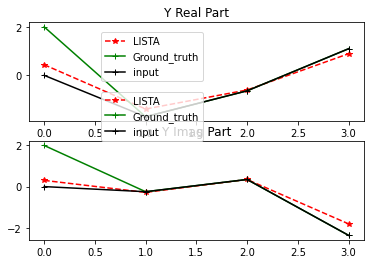

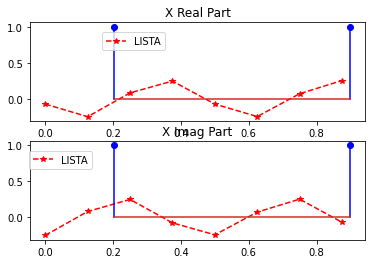

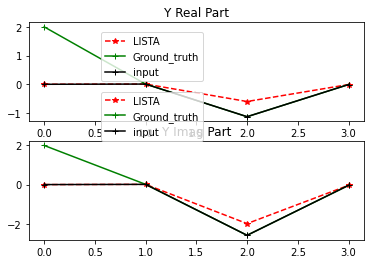

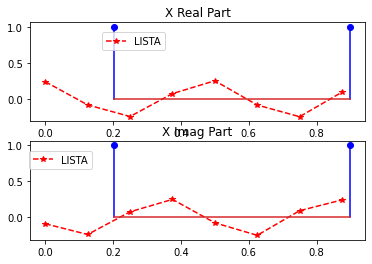

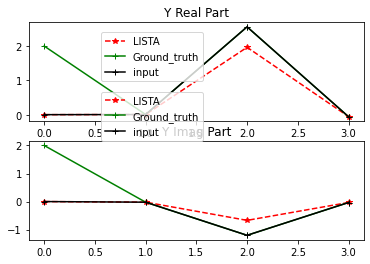

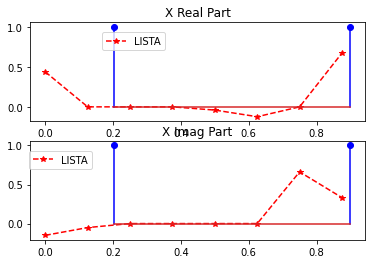

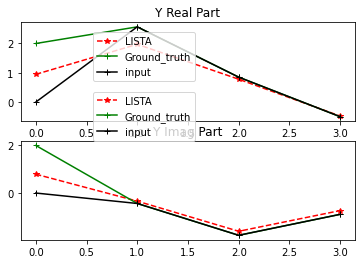

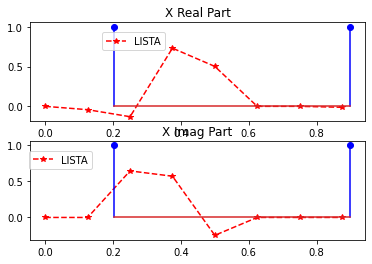

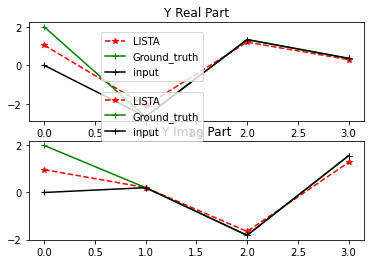

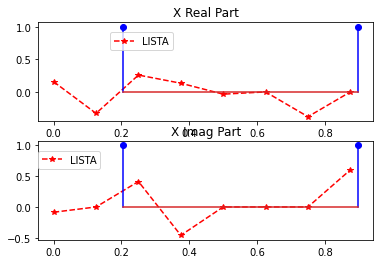

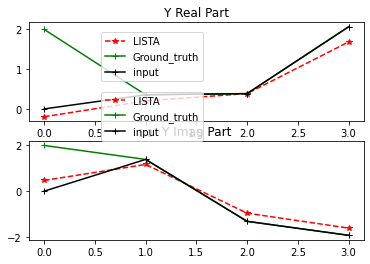

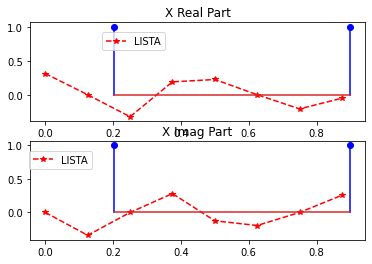

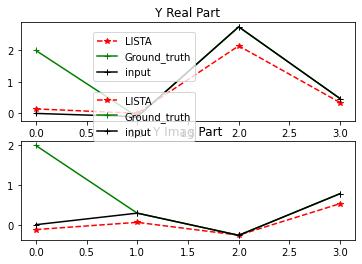

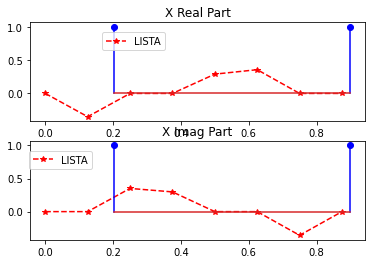

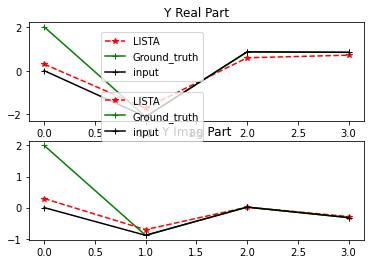

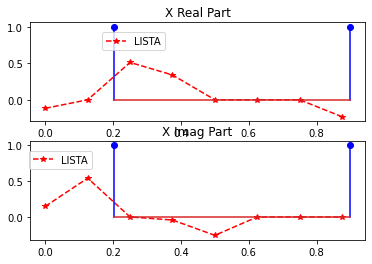

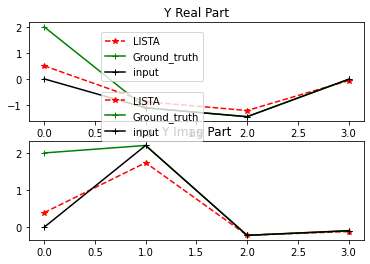

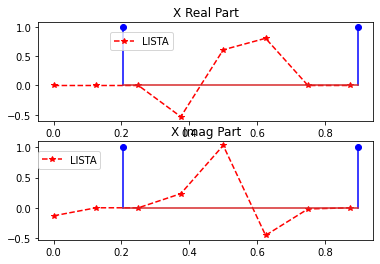

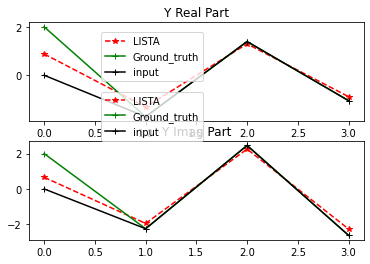

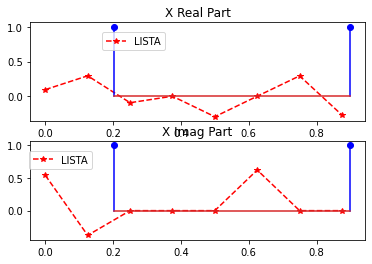

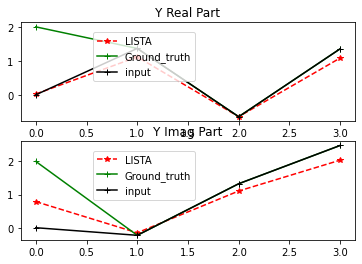

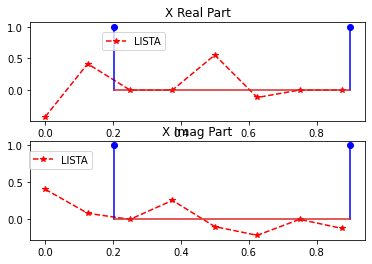

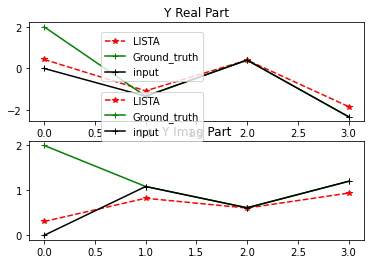

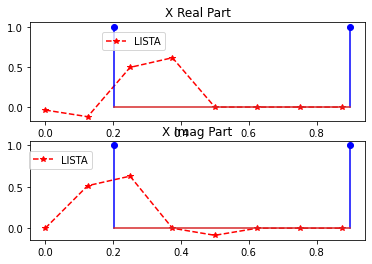

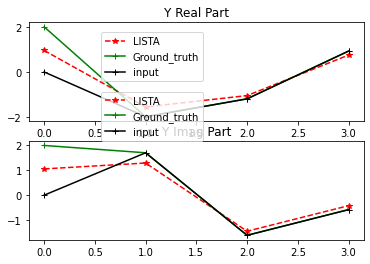

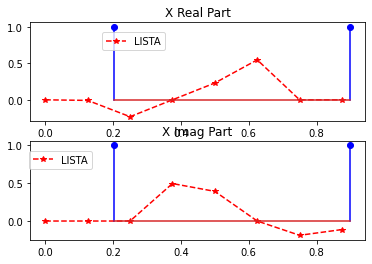

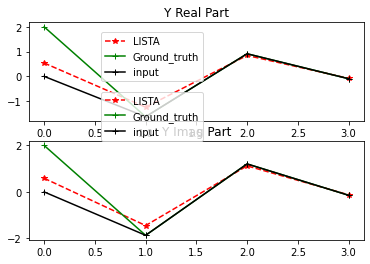

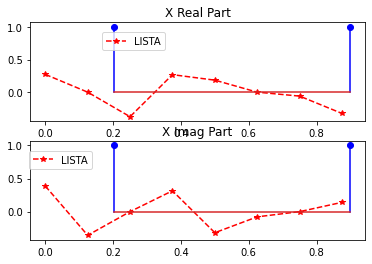

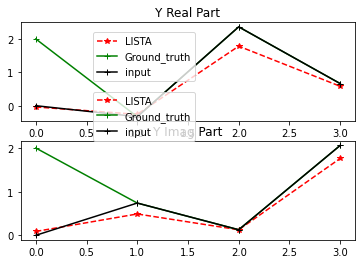

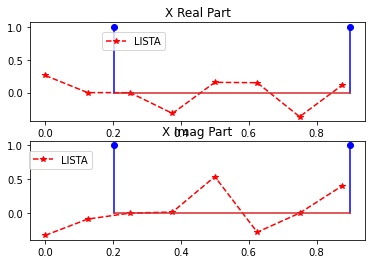

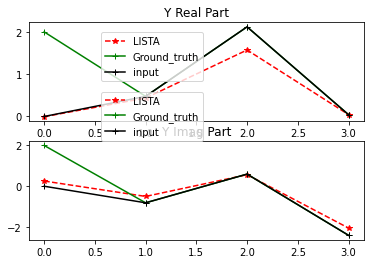

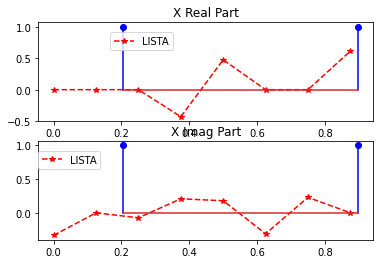

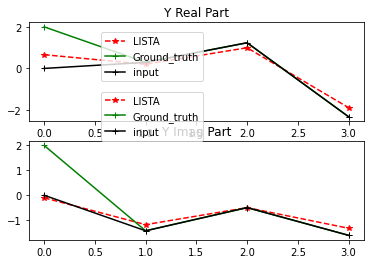

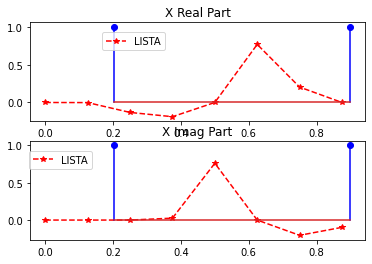

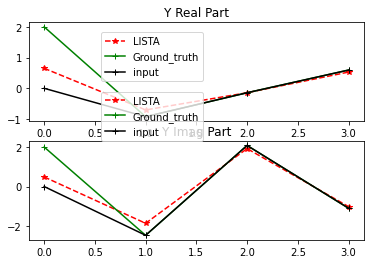

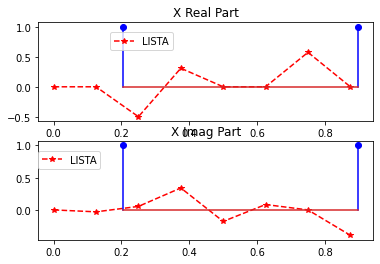

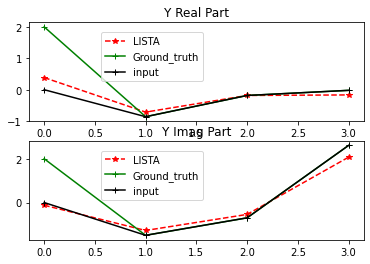

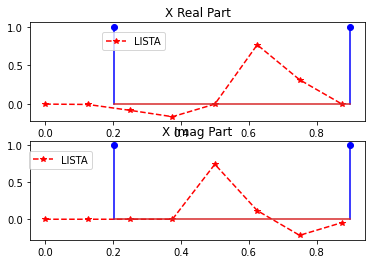

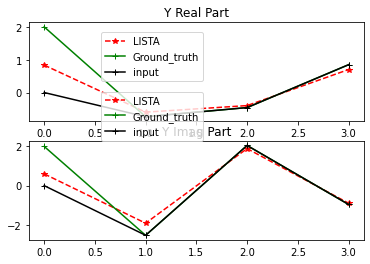

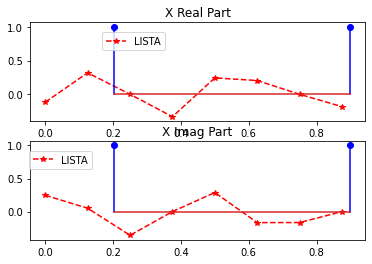

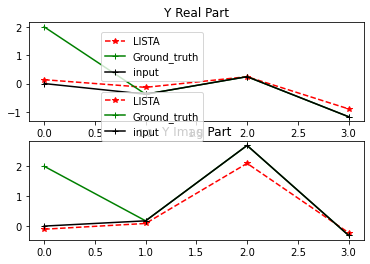

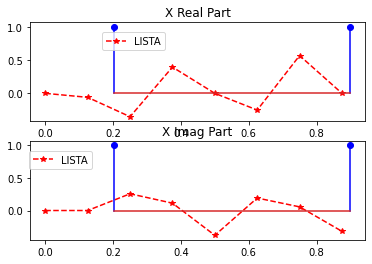

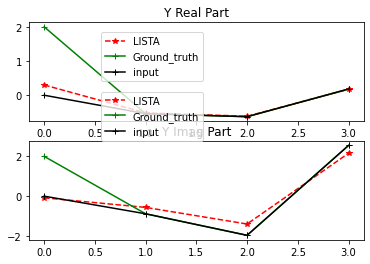

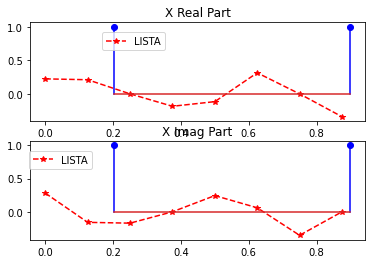

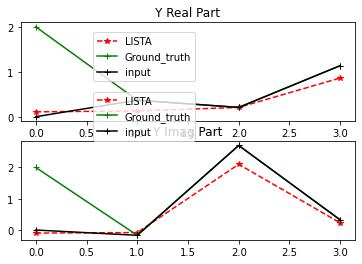

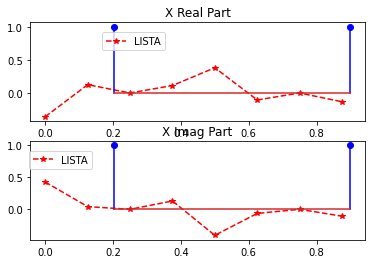

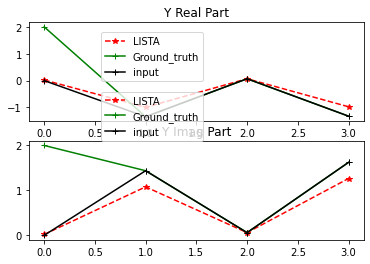

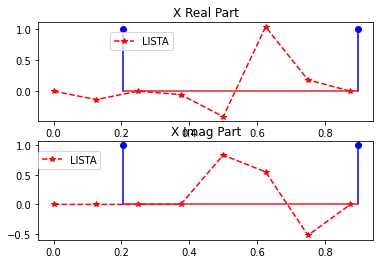

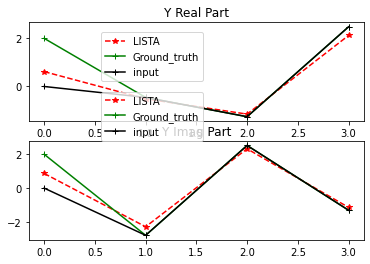

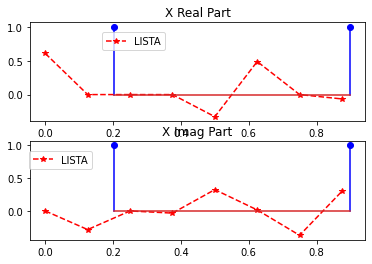

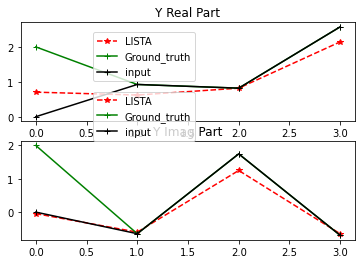

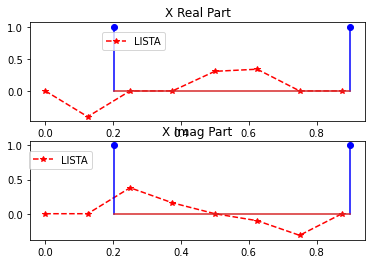

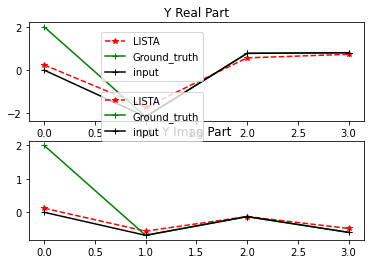

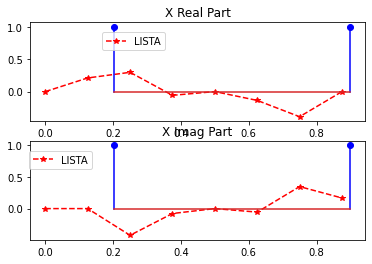

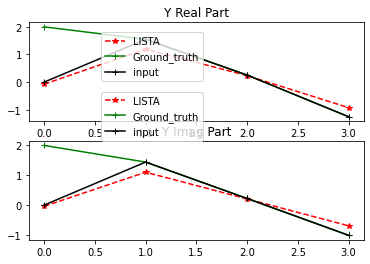

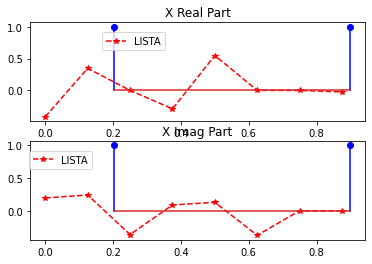

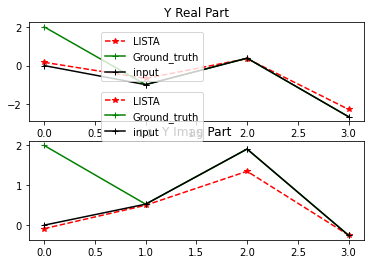

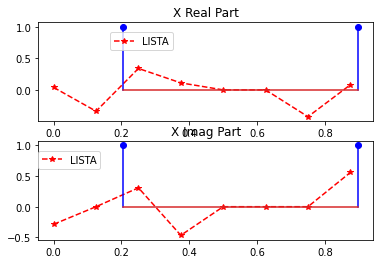

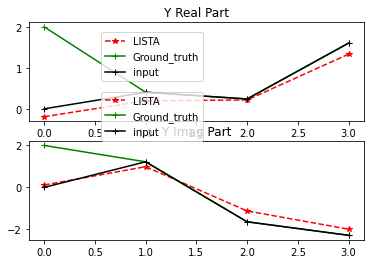

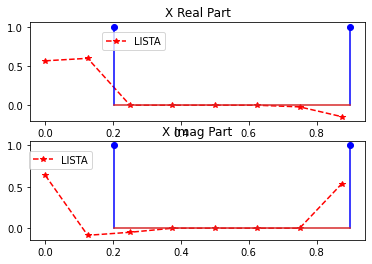

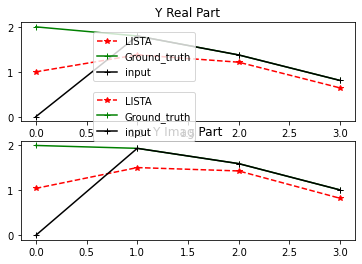

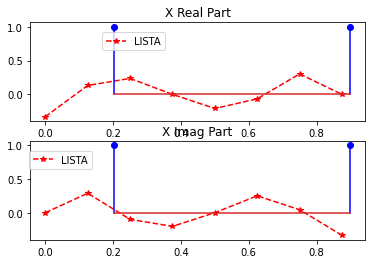

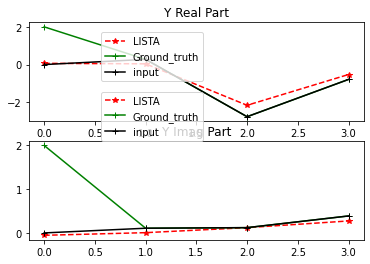

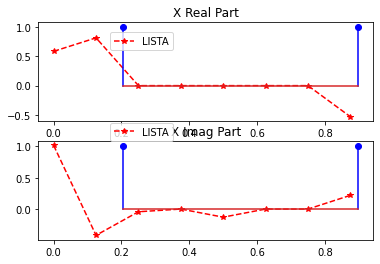

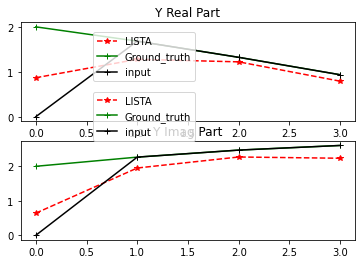

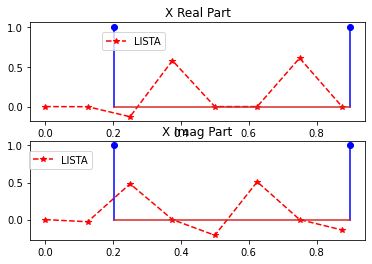

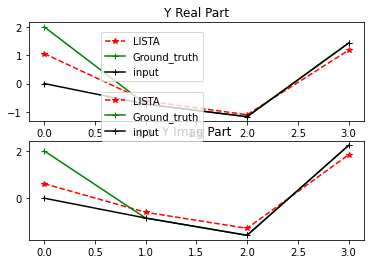

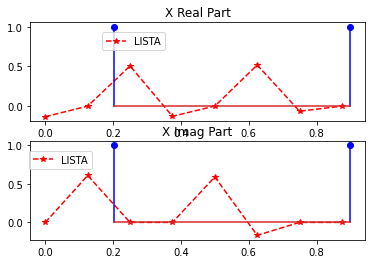

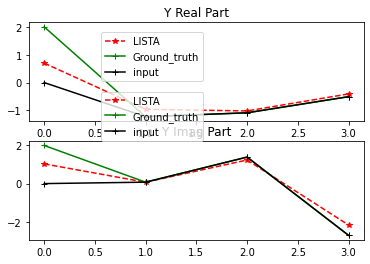

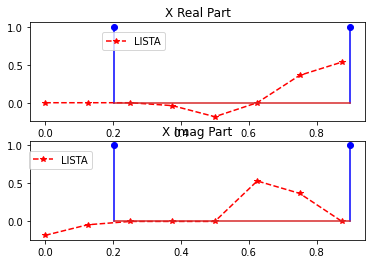

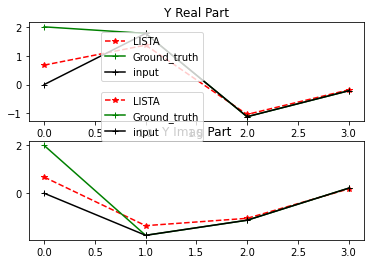

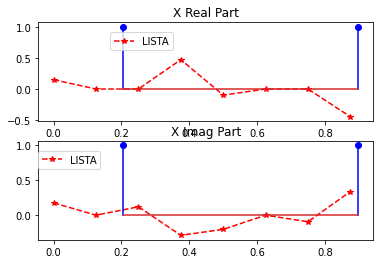

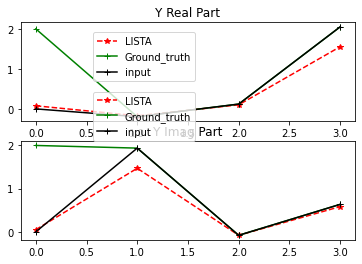

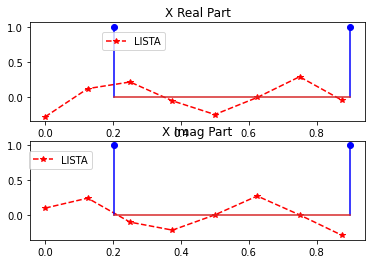

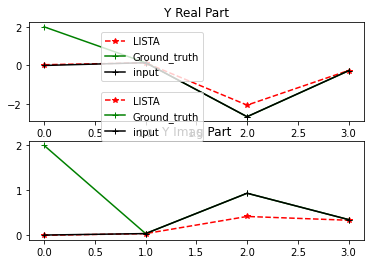

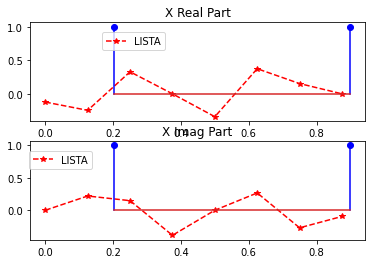

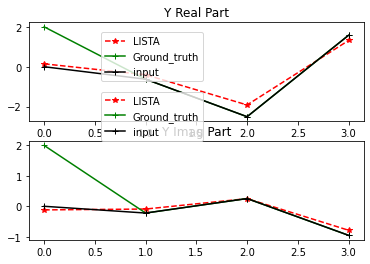

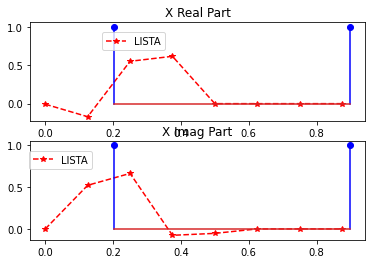

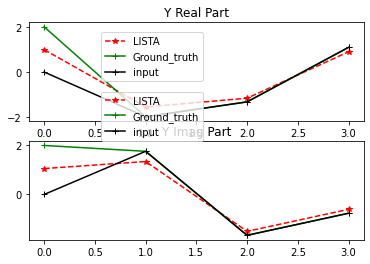

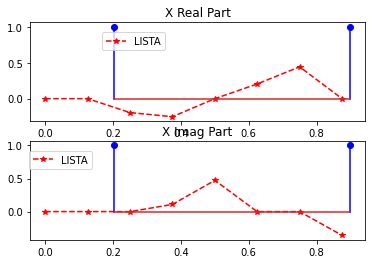

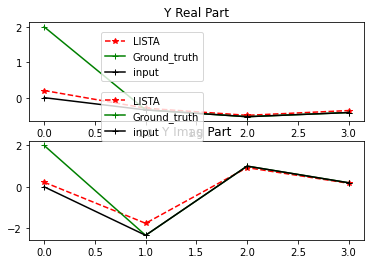

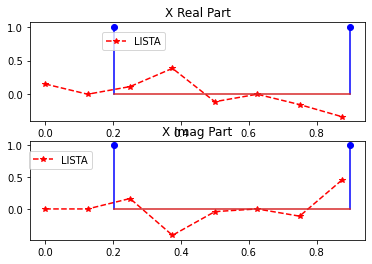

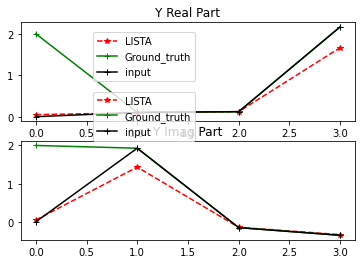

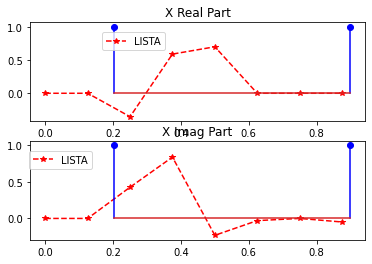

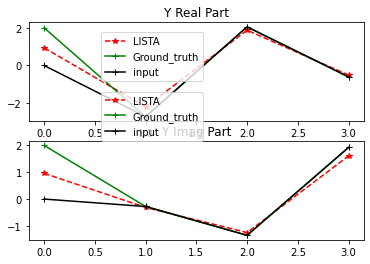

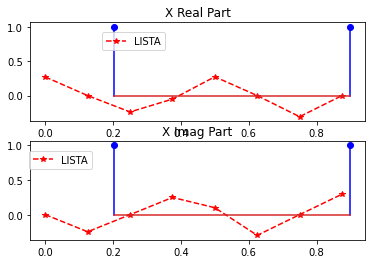

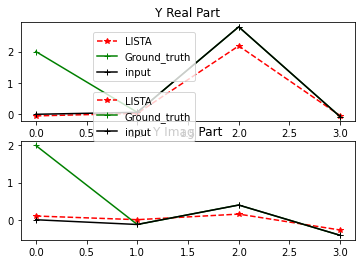

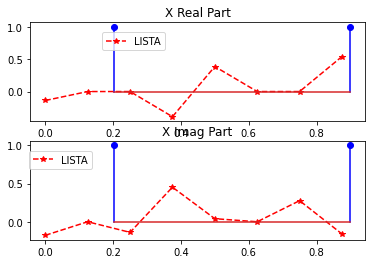

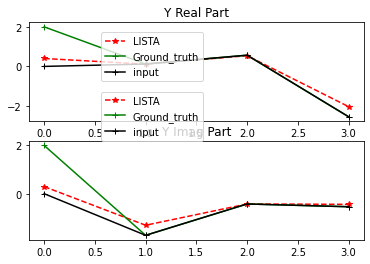

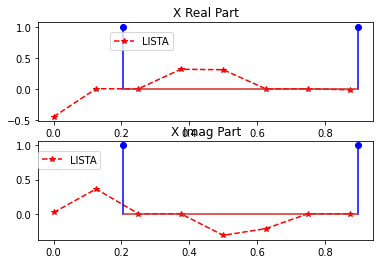

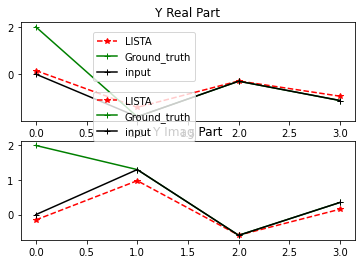

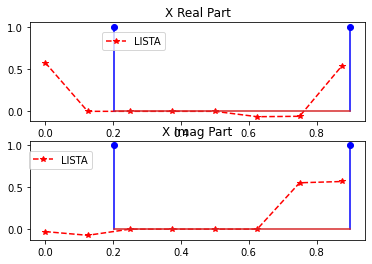

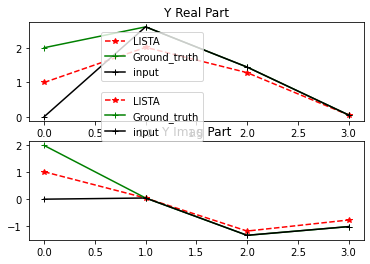

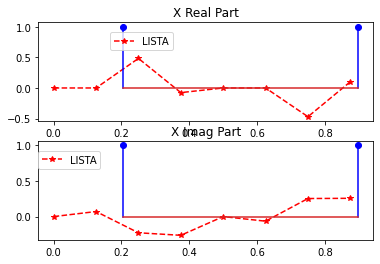

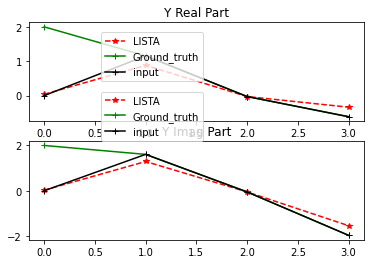

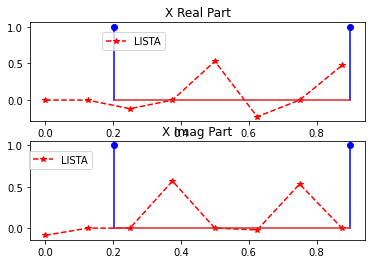

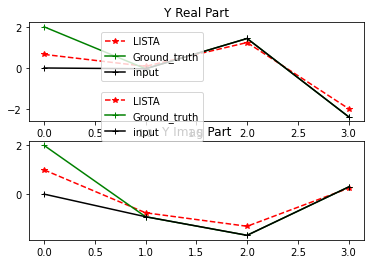

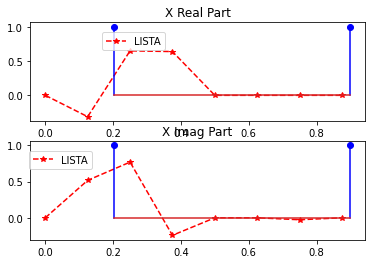

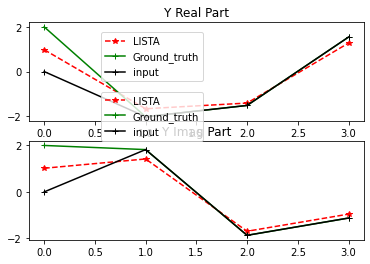

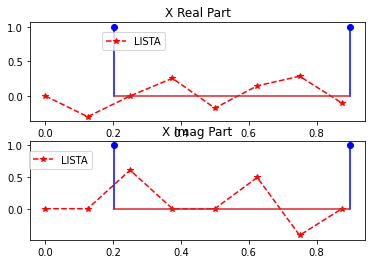

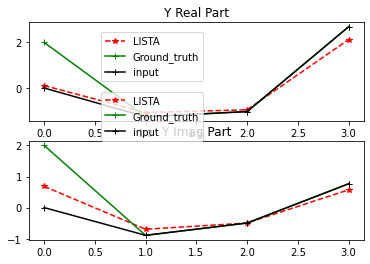

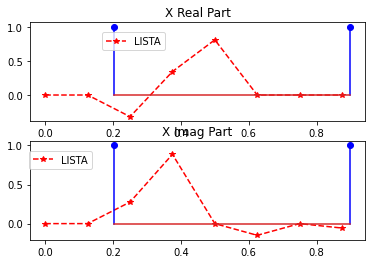

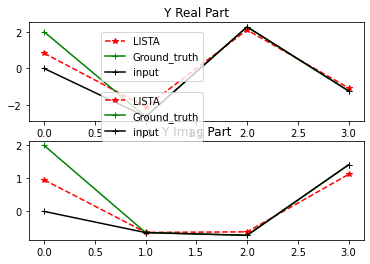

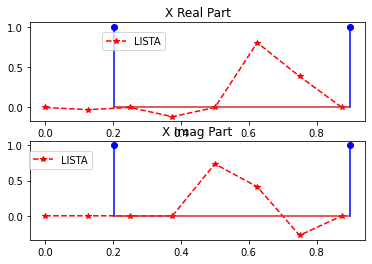

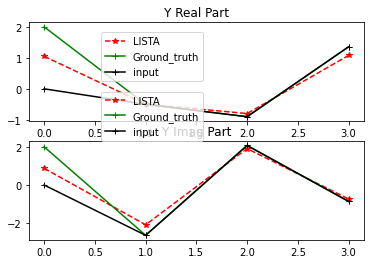

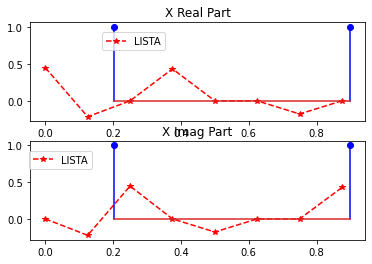

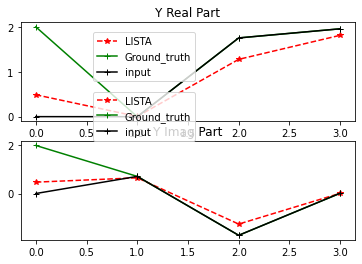

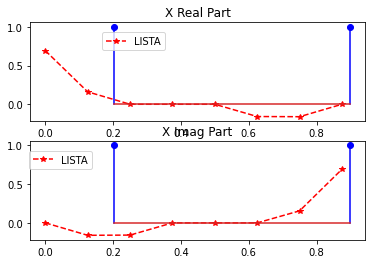

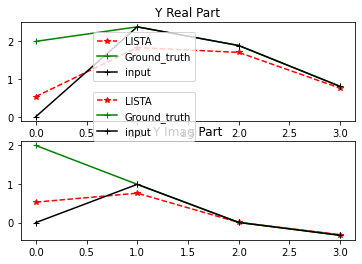

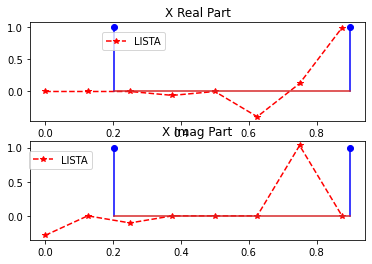

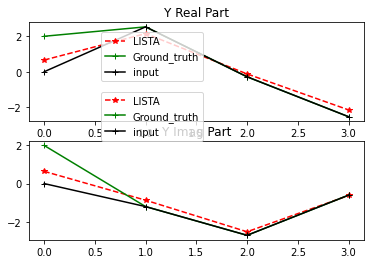

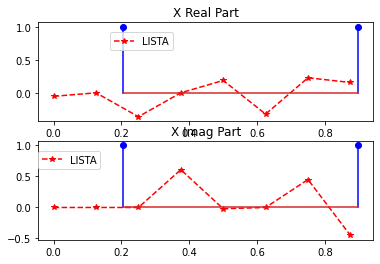

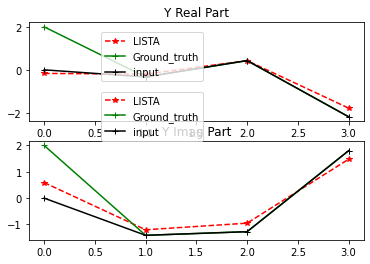

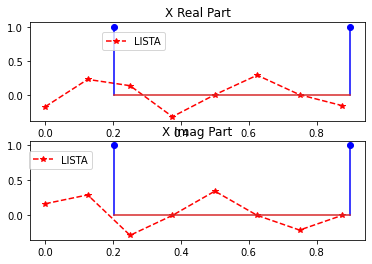

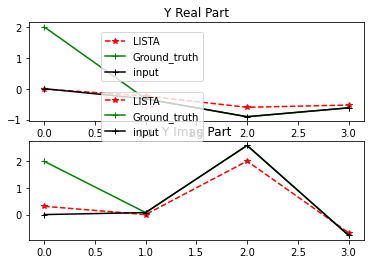

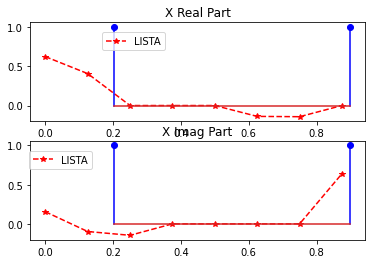

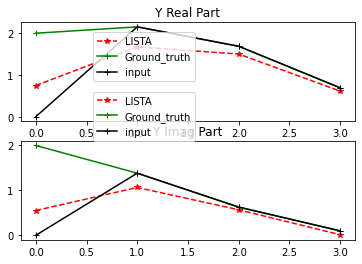

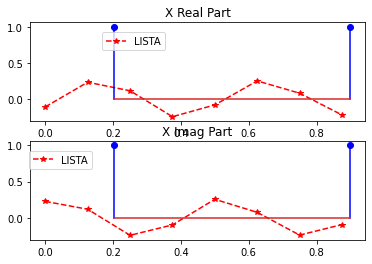

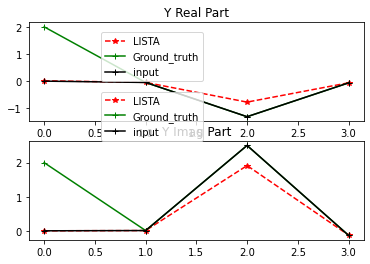

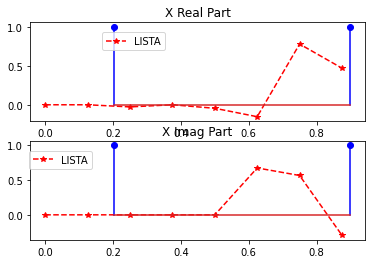

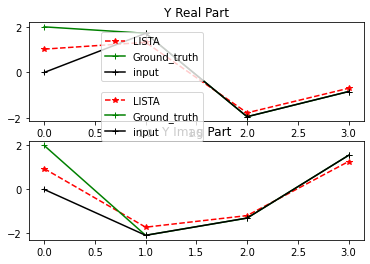

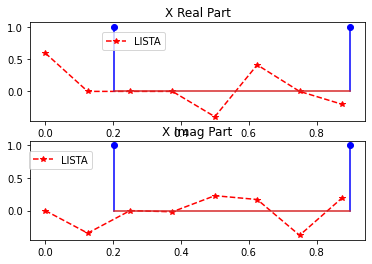

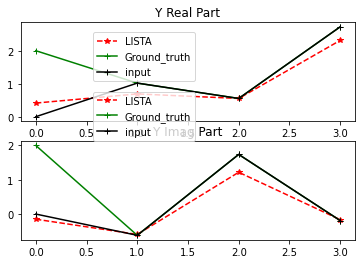

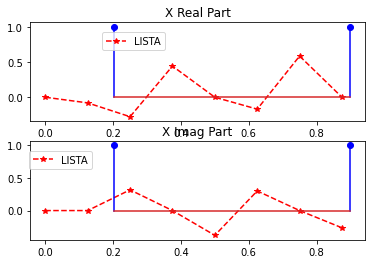

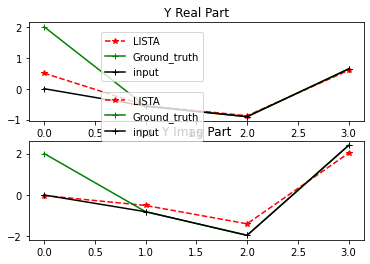

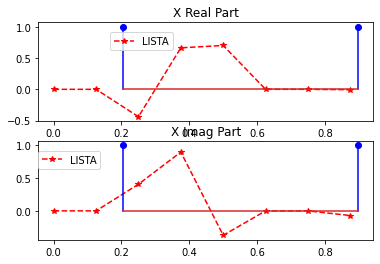

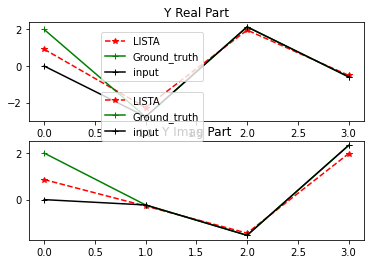

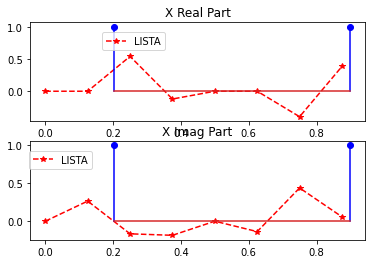

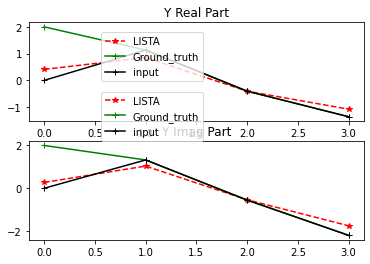

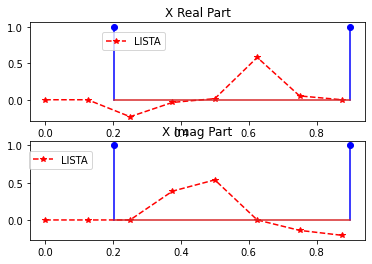

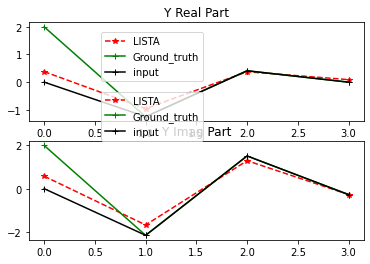

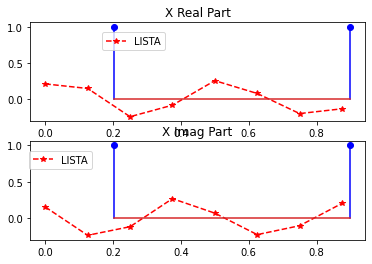

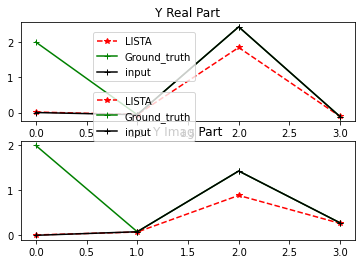

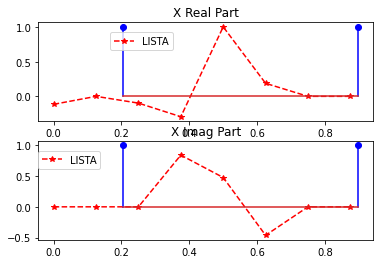

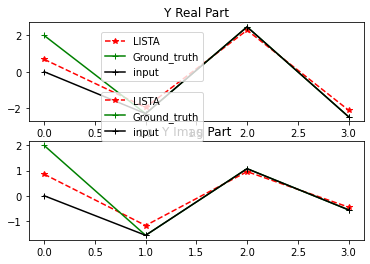

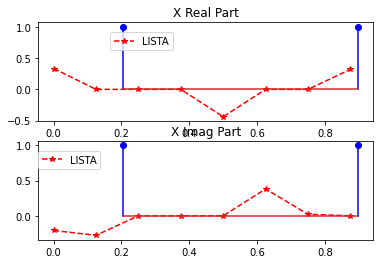

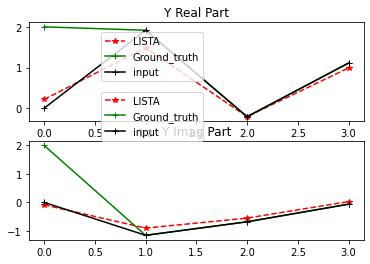

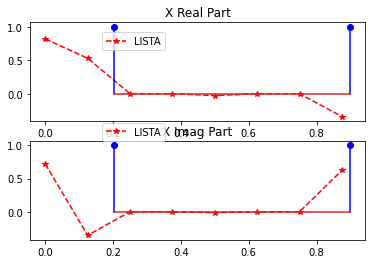

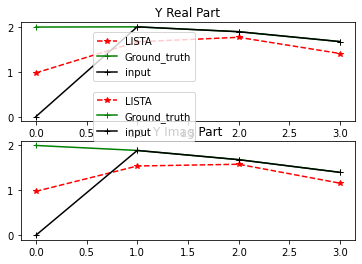

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: yinchuan li
@version: 2020.03.12
Change to complex-valued network
Off-grid LISTA net
Change the loss to y-loss
where in the network return x, and in the loss we use y-Cx
"""

import numpy as np
import matplotlib.pyplot as plt
# from LISTA_E_BBB import my_lista
import random as rd
import torch
from scipy.special import comb, perm
batch_size = 2048
learning_rate = 1e-3
stage = 6
# dimensions of the sparse signal x
n = 8
# dimension of the compressed signal y
m = 4
# sparsity : non-zero values over n
sparsity = 2

# training and testing number:
train_number = 500000
valid_number = 1000
# number of training iterations (epochs)
numIter = 100

# w state of randomness
# rng = np.random.RandomState(23)

# create the 1:N sample
sample = np.array(list(range(m))).reshape(m, 1)
# create the frequency grid
f_grid = 1/n*np.array(list(range(n))).reshape(1, n)

# generate the dictionary, without the sampling matrix Phi
# C = np.exp(1j*2*np.pi*np.matmul(sample, f_grid))
# A = C.copy()

# generate the dictionary with the sampling matrix Phi
C = np.exp(1j*2*np.pi*np.matmul(sample, f_grid))
phi = np.zeros([m])
p = 0.8 # sparsity level
Ns = int(np.floor((p)*m)) # the sampling number, note that should be int
index = rd.sample(range(m),Ns)
phi[index] = 1
Phi = np.diag(phi)
A = np.matmul(Phi,C)


# generate off-grid training/testing data
def generate_off_grid_data(m, n, Phi, sparsity, bs, SNR=20):
    w_real = np.zeros([sparsity, bs])
    w_imag = np.zeros([sparsity, bs])
    Y_star = np.zeros((m, bs)) + 1j * np.zeros((m, bs))
    Y = np.zeros((m, bs)) + 1j * np.zeros((m, bs))
    w_star = np.zeros([sparsity, bs]) + 1j * np.zeros([sparsity, bs])
    distance = 2/(n-1)
    f_interval = np.arange(0,sparsity*distance,distance)

    for i in range(bs):
        # f_star = (1-(sparsity-1)*distance) * np.sort(np.random.random((sparsity))) + f_interval
        f_star = np.sort(np.random.random((sparsity)))
        f_star = f_star.reshape(1,sparsity)
        Cf = np.exp(1j * 2 * np.pi * np.matmul(sample, f_star))

        w_real[:, i] = np.ones(sparsity)
        w_imag[:, i] = np.ones(sparsity)
        # w_real[:, i] = 2*np.random.random((sparsity))-1
        # w_imag[:, i] = 2*np.random.random((sparsity))-1
        w_star[:, i] = w_real[:, i] + 1j * w_imag[:, i]
        Y_star[:, i]  = np.matmul(Cf,w_star[:, i])
        Y[:, i] = np.matmul(Phi,Y_star[:, i])

    return Y, Y_star, f_star, w_star

train_input, train_output, f_star, w_star = generate_off_grid_data(m, n, Phi, sparsity, train_number)
valid_input, valid_output, f_star, w_star = generate_off_grid_data(m, n, Phi, sparsity, valid_number)

# print(y_train[:,1])
# print(x_train[:,1])

# compute the max eigen value of the w'*w
# alpha = np.linalg.norm(A,ord=2) ** 2
alpha = 5
# regularization paramter
_lambda = 0.5

SNR_list = []

Y_pred_real, Y_pred_imag, X_pred_real, X_pred_imag, err_list = my_lista(A, C, Phi, train_input, train_output, valid_input, valid_output,
                                               _lambda, alpha, bs=batch_size, epochs=numIter, stage = stage, learning_rate = learning_rate)
Y_pred_lista = Y_pred_real + 1j*Y_pred_imag


wt_gt_real = torch.from_numpy(w_star.real)
wt_gt_imag = torch.from_numpy(w_star.imag)

yt_gt_real = torch.from_numpy(valid_output.real)
yt_gt_imag = torch.from_numpy(valid_output.imag)

y_valid_input_real = torch.from_numpy(valid_input.real)
y_valid_input_imag = torch.from_numpy(valid_input.imag)


f_grid_plt = f_grid.reshape(n)
f_star_plt = f_star.reshape(sparsity)
for i in range(100):
    plt.figure()
    plt.subplot(211)
    plt.plot(f_grid_plt, X_pred_real[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))

    plt.stem(f_star_plt, wt_gt_real.detach().numpy()[:, i], linefmt='b-', markerfmt='bo')

    plt.title("X Real Part")

    plt.subplot(212)
    plt.plot(f_grid_plt, X_pred_imag[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
    plt.stem(f_star_plt, wt_gt_imag.detach().numpy()[:, i], linefmt='b-', markerfmt='bo')

    plt.title("X Imag Part")
    # plt.show()
    plt.savefig('X_plot_new_{}_v2.jpg'.format(i))

    plt.figure()
    plt.subplot(211)
    plt.plot(Y_pred_real[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.plot(yt_gt_real.detach().numpy()[:, i], color='green', linestyle='-', marker='+', linewidth=1.5,
             label='Ground_truth')
    plt.plot(y_valid_input_real.detach().numpy()[:, i], color='black', linestyle='-', marker='+', linewidth=1.5,
             label='input')
    plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
    plt.title("Y Real Part")

    plt.subplot(212)
    plt.plot(Y_pred_imag[:, i], color='red', linestyle='--', marker='*', linewidth=1.5,
             label='LISTA')
    plt.plot(yt_gt_imag.detach().numpy()[:, i], color='green', linestyle='-', marker='+', linewidth=1.5,
             label='Ground_truth')
    plt.plot(y_valid_input_imag.detach().numpy()[:, i], color='black', linestyle='-', marker='+', linewidth=1.5,
             label='input')
    plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
    plt.title("Y Imag Part")
    # plt.show()
    plt.savefig('Y_plot_new_{}_v2.jpg'.format(i))



In [ ]:
Y_pred_imag.shape

(4, 1000)

Text(0.5, 1.0, 'Y Imag Part')

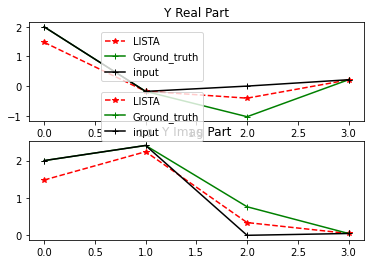

In [ ]:
digit = 15
plt.figure()
plt.subplot(211)
plt.plot(Y_pred_real[:, digit], color='red', linestyle='--', marker='*', linewidth=1.5,
          label='LISTA')
plt.plot(yt_gt_real.detach().numpy()[:, digit], color='green', linestyle='-', marker='+', linewidth=1.5,
          label='Ground_truth')
plt.plot(y_valid_input_real.detach().numpy()[:, digit], color='black', linestyle='-', marker='+', linewidth=1.5,
          label='input')
plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
plt.title("Y Real Part")

plt.subplot(212)
plt.plot(Y_pred_imag[:, digit], color='red', linestyle='--', marker='*', linewidth=1.5,
          label='LISTA')
plt.plot(yt_gt_imag.detach().numpy()[:, digit], color='green', linestyle='-', marker='+', linewidth=1.5,
          label='Ground_truth')
plt.plot(y_valid_input_imag.detach().numpy()[:, digit], color='black', linestyle='-', marker='+', linewidth=1.5,
          label='input')
plt.legend(loc='best', bbox_to_anchor=(0.2, 0.95))
plt.title("Y Imag Part")